# APPROXIMATE ARC LENGTH PARAMETRIZATION USING CUBIC BEZIER CURVES

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import kron
import cvxpy as cp
from scipy.interpolate import CubicSpline
%matplotlib inline

In [81]:
#track

trackx = 20 * np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, \
                  0.8 ,0.8 ,0.8 ,0.8, 0.75, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.0, 0.0, 0.0, 0.0 ]) 
tracky = 10 * np.array([0.05, 0.3, 0.4, 0.2, 0.2, 0.0, 0.0, 0.0, 0.05, \
                  0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.5, 0.3, 0.3, 0.5, 0.5, 0.5, 0.45, 0.4, 0.3, 0.2, 0.1 ]) 
waypoints = np.vstack([trackx,tracky]).T

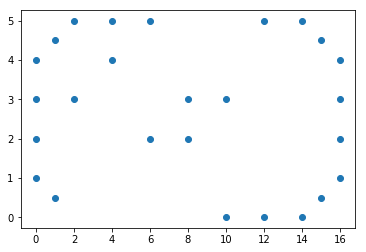

In [82]:

plt.scatter(trackx, tracky)


In [83]:
def interpolateclosedBezier(waypoints):
    n = len(waypoints)
    M = np.zeros([n,n])

    #build M
    tridiagel = np.matrix([[1, 4, 1]])
    for idx in range(n-2):
        M[idx+1:idx+2, idx:idx+3] = tridiagel

    M[0,0:2]= tridiagel[:,1:3]
    M[-1,-2:]= tridiagel[:,0:2]
    M[0:2,-1] = tridiagel[:,0].reshape(1,-1)
    M[-1,0] = tridiagel[:,0].reshape(1,-1)


    #build sol vector
    s =np.zeros([n,2])
    for idx in range(n-1):
        s[idx,:] = 2*(2*waypoints[idx,:] + waypoints[idx+1,:])
    s[-1:] = 2*(2*waypoints[-1,:] + waypoints[0,:])
    
    #solve for a & b
    Ax = np.linalg.solve(M,s[:,0])
    Ay = np.linalg.solve(M,s[:,1])

    a = np.vstack([Ax,Ay])
    b = np.zeros([2,n])

    b[:,:-1] = 2*waypoints.T[:,1:] - a[:,1:]
    b[:,-1] = 2*waypoints.T[:,0] - a[:,0]
    
    return a, b
    
def evalclosedBezier(waypoints, a, b, t):
    segment = np.floor(t)
    segment = np.int(segment)
    n = len(waypoints)
    if segment>=n:
        t =n-0.0001
        segment = n-1
    elif t<0:
        t = 0
    t_val = t-segment
    coords = np.power(1 - t_val, 3) * waypoints.T[:,segment] + 3 * np.power(1 - t_val, 2) * t_val * a[:,segment]\
    + 3 * (1 - t_val) * np.power(t_val, 2) * b[:,segment] + np.power(t_val, 3) * waypoints.T[:,np.int(np.mod(segment+1,n))]
    
    return coords

def getangleBezier(waypoints, a, b, t):
    der = evalclosedBezier(waypoints, a, b, t+0.1) - evalclosedBezier(waypoints, a, b, t)
    phi = np.arctan2(der[1]/der[0])
    return der, phi

def computeT(coef,order, s):
    res = 0
    for idx in range(order):
        res += coef[idx]*np.power(s,order-idx)
    return res


In [84]:
%matplotlib qt
npoints = 200
a, b = interpolateclosedBezier(waypoints)
coords =[]
tvals = np.linspace(0, 26, npoints+1)
for t in tvals:
    coords.append(evalclosedBezier(waypoints, a, b, t))

coords = np.array(coords)
coords.shape

plt.plot(coords[:,0],coords[:,1])
plt.scatter(trackx, tracky)


In [86]:
#compute approx distance to arc param
dists = []
dists.append(0)

for idx in range(npoints):
    dists.append(np.sqrt(np.sum(np.square(coords[idx,:]-coords[np.mod(idx+1,npoints-1),:]))))
    
dists = np.cumsum(np.array(dists))

plt.figure()
plt.plot(tvals, dists)
plt.xlabel("t (Bezier param) [-]")
plt.ylabel("s (approx. distance traveled) [m] ")

Text(0, 0.5, 's (approx. distance traveled) [m] ')

In [63]:
dists.shape


(201,)

In [70]:
'''
#interpolation order
order = 10
norm = 1

coef = cp.Variable((order,1))
#create regressor
A = dists.reshape(-1,1)
for idx in range(order-1):
    print('ord conc %f', idx+2)
    A = np.concatenate((np.power(dists,idx+2).reshape(-1,1),A), axis =1)
y = tvals.reshape(-1,1)

gamma = 0.01
objective = cp.Minimize(cp.pnorm(A@coef-y,norm) + gamma * cp.norm(coef,2))
constraint = []
constraint.append((A@coef)[-1] == y[-1])
prob = cp.Problem(objective, constraint)
result = prob.solve(solver = 'ECOS', verbose=True)

coeffs = coef.value

'''

ts_inverse = CubicSpline(dists, tvals)

In [66]:
(A@coef-y).shape

(201, 1)

In [71]:
smax = dists[-1]
svals = np.linspace(0, smax, npoints)
t_corr = ts_inverse(svals) #computeT(coeffs,order,svals)

plt.figure()
plt.plot(tvals, dists)
plt.plot(t_corr, svals)
plt.xlabel("t (Bezier param) [-]")
plt.ylabel("s (approx. distance traveled) [m] ")

Text(0, 0.5, 's (approx. distance traveled) [m] ')

In [72]:
coords_corr = []

for t in t_corr:
    coords_corr.append(evalclosedBezier(waypoints, a, b, t))

coords_corr = np.array(coords_corr)

plt.figure()
plt.plot(coords_corr[:,0],coords_corr[:,1])
plt.scatter(trackx, tracky)
plt.scatter(coords_corr[:,0],coords_corr[:,1], s=10)


dists_corr = []

for idx in range(npoints):
    dists_corr.append(np.sqrt(np.sum(np.square(coords_corr[idx,:]-coords_corr[np.mod(idx+1,npoints-1),:]))))
    
dists_corr = np.cumsum(np.array(dists_corr))

plt.figure()
#plt.plot(tvals, dists)
plt.plot([0, 4], [0, 4])
plt.plot(svals, dists_corr)
plt.legend(["x=y","arclength vs t_corr"])
plt.xlabel("t (Bezier param corr ) [m]")
plt.ylabel("s (approx. distance traveled) [m] ")

Text(0, 0.5, 's (approx. distance traveled) [m] ')

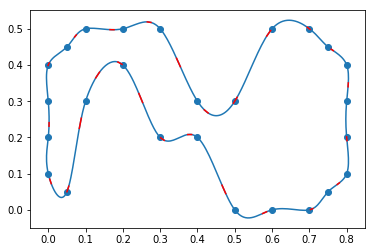

In [89]:
plt.figure()
plt.plot(coords_corr[:,0],coords_corr[:,1])
plt.scatter(trackx, tracky)

der = []
for t in t_corr:
    der.append(getangleBezier(waypoints, a, b, t))
der = np.array(der)

downsampling = 20
scaling = 1
for idx in range(np.int(np.floor(len(coords)/downsampling))):
    idxeval = int(idx*downsampling)
    plt.plot([coords_corr[idxeval,0],coords_corr[idxeval,0] + scaling*der[idxeval,0]]\
             ,[coords_corr[idxeval,1],coords_corr[idxeval,1] + scaling*der[idxeval,1]], color='r')




In [88]:
getangleBezier(waypoints, a, b, 9)

array([0.002294  , 0.00776036])

In [24]:
dists


array([ 0.        ,  0.07831925,  0.16965779,  0.27298709,  0.38714937,
        0.51091795,  0.6430267 ,  0.78218593,  0.92709158,  1.07643107,
        1.22888718,  1.38314117,  1.53787526,  1.69177523,  1.84353311,
        1.99185064,  2.1354438 ,  2.27304927,  2.403434  ,  2.52541037,
        2.64074977,  2.75518765,  2.86829253,  2.97938697,  3.08780911,
        3.1929196 ,  3.29411097,  3.39082051,  3.48254891,  3.56888738,
        3.6495582 ,  3.72447551,  3.79383508,  3.85823982,  3.9188519 ,
        3.97751758,  4.03675134,  4.09948658,  4.16867931,  4.24695431,
        4.33564564,  4.43459571,  4.54306564,  4.6600016 ,  4.78416451,
        4.91420219,  5.04869146,  5.18616429,  5.32512504,  5.46406294,
        5.60146235,  5.73581228,  5.86561725,  5.98941118,  6.10577778,
        6.21338331,  6.31103318,  6.39777708,  6.47312819,  6.5381704 ,
        6.59580458,  6.64906705,  6.70061792,  6.752394  ,  6.80549585,
        6.86030062,  6.91666382,  6.97411092,  7.03199093,  7.08

In [91]:
len(waypoints)

26